# Time series analysis with HyP3 and MintPy

This notebook walks through performing a time-series analysis of the 2019 Ridgecrest, CA earthquake with On Demand InSAR products from the Alaska Satellite facility and MintPy. We'll:

1. Use the [ASF Search Python package](https://docs.asf.alaska.edu/asf_search/basics/) to:
   - Search ASF's catalog for Sentinel-1 SAR products covering the [Ridgecrest earthquake](https://earthquake.usgs.gov/storymap/index-ridgecrest.html)
   - Select a reference scene to generate a baseline stack
   - Select a [short baseline subset (SBAS)](https://docs.asf.alaska.edu/vertex/sbas/) of scene pairs for InSAR processing


2. Use the [HyP3 Python SDK](https://hyp3-docs.asf.alaska.edu/using/sdk/) to:
   - Request On Demand InSAR products from ASF HyP3
   - Download the InSAR products when they are done processing


3. Use [GDAL](https://gdal.org/api/index.html#python-api) and [MintPy](https://mintpy.readthedocs.io/en/latest/) to:
   - Prepare the InSAR products for MintPy
   - perform a time-series analysis with MintPy
   
---

**Note:** This notebook does assume you have some familiarity with InSAR processing with MintPy already, and is a minimal example without much context or explanations. If you're new to InSAR and MintPy, I suggest checking out:
* our [InSAR on Demand Story Map](https://storymaps.arcgis.com/stories/68a8a3253900411185ae9eb6bb5283d3)


* [OpenSARlab's](https://opensarlab-docs.asf.alaska.edu/) highly detailed walkthrough of using HyP3 + MintPy via these notebooks:
  * [Prepare a HyP3 InSAR Stack for MintPy](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/Prepare_HyP3_InSAR_Stack_for_MintPy.ipynb)
  * [MintPy Time-series Analysis](https://nbviewer.org/github/ASFOpenSARlab/opensarlab-notebooks/blob/master/SAR_Training/English/Master/MintPy_Time_Series_From_Prepared_Data_Stack.ipynb)
  
    Note: While these notebooks make some assumptions you're working in OpenSARlab, you can run these 
    notebooks outside OpenSARlab by creating [this conda environment](https://github.com/ASFOpenSARlab/opensarlab-envs/blob/main/Environment_Configs/insar_analysis_env.yml).

## 0. Initial Setup

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:
```shell
conda create -n hyp3-mintpy python=3.10 "asf_search>=7.0.0" hyp3_sdk "mintpy>=1.5.2" pandas jupyter ipympl

conda activate hyp3-mintpy
jupyter notebook hyp3_insar_stack_for_ts_analysis.ipynb
```
Or, install these dependencies into your own environment:
```shell
conda install python=3.10 "asf_search>=7.0.0" hyp3_sdk "mintpy>=1.5.2" pandas jupyter ipympl

jupyter notebook hyp3_insar_stack_for_ts_analysis.ipynb
```

In [2]:
from pathlib import Path

from dateutil.parser import parse as parse_date

### Set parameters

In [47]:
# === Define project paths ===
project_name = "aoi_3_bologna"

# Directory where HyP3 products (SLCs/interferograms) are stored
data_dir = Path("/mnt/data") / project_name
hyp_int_dir = data_dir / "hyp_int"  # For interferograms only

# Working directory for MintPy, config files, etc.
work_dir = Path.home() / "work" / "aoi_bologna" / "aoi_3_1"

# Create necessary folders if they don't exist
for d in [data_dir, hyp_int_dir, work_dir]:
    d.mkdir(parents=True, exist_ok=True)

print("✔️ Project setup complete:")
print(f"  - Data directory:      {data_dir}")
print(f"  - HyP3 interferograms: {hyp_int_dir}")
print(f"  - Work directory:      {work_dir}")


✔️ Project setup complete:
  - Data directory:      /mnt/data/aoi_3_bologna
  - HyP3 interferograms: /mnt/data/aoi_3_bologna/hyp_int
  - Work directory:      /home/ubuntu/work/aoi_bologna/aoi_3_1


In [4]:
# --- Define search configuration ---
stack_start = parse_date("2016-12-31T23:00:00Z")
stack_end = parse_date("2025-06-30T21:59:59Z")
max_temporal_baseline = 24  # days, used later for SBAS pair filtering (optional)

## 1. Select InSAR pairs with ASF Search

In [5]:
import asf_search as asf
from pprint import pprint


In [ ]:

# Define ASF search parameters
opts = asf.ASFSearchOptions(**{
    "maxResults": 5000,
    "bbox": [11.2, 44.4, 11.5, 44.6],  # Bologna AOI (EPSG:32633) POLYGON((11.2 44.4,11.5 44.4,11.5 44.6,11.2 44.6,11.2 44.4))
    "beamSwath": ["IW"],
    "flightDirection": "DESCENDING",
    "polarization": ["VV+VH", "VV"],
    "processingLevel": ["SLC"],
    "start": stack_start.isoformat(),
    "end": stack_end.isoformat(),
    "dataset": ["SENTINEL-1"]
})

# Search SLC scenes from ASF
search_results = asf.search(opts=opts)
print(f"🔍 Found {len(search_results)} scenes.")

# Create baseline stack (SBAS-compatible) from the most recent scene
baseline_results = asf.baseline_search.stack_from_product(search_results[-1])
print(f"Generated {len(baseline_results)} SBAS pairs.")

# Preview first few SBAS pairs
pprint(baseline_results[:3])


In [14]:
import pandas as pd


# Dynamically get all properties
columns = list(baseline_results[0].properties.keys()) + ['geometry']
data = [list(scene.properties.values()) + [scene.geometry] for scene in baseline_results]

# Create DataFrame
stack = pd.DataFrame(data, columns=columns)

# Show available columns to inspect
print("Available DataFrame columns:")
print(stack.columns.tolist())

# Convert to datetime
stack['startTime'] = stack['startTime'].apply(parse_date)

# Filter by date range
stack = stack.loc[(stack_start <= stack.startTime) & (stack.startTime <= stack_end)]

# Show preview using safe subset
preview_cols = [col for col in ['sceneName', 'startTime', 'stopTime'] if col in stack.columns]
print(f"Filtered SBAS stack: {len(stack)} pairs")
stack[preview_cols].head()


Available DataFrame columns:
['centerLat', 'centerLon', 'stopTime', 'fileID', 'flightDirection', 'pathNumber', 'processingLevel', 'url', 'startTime', 'sceneName', 'browse', 'platform', 'bytes', 'md5sum', 'frameNumber', 'granuleType', 'orbit', 'polarization', 'processingDate', 'sensor', 'groupID', 'pgeVersion', 'fileName', 'beamModeType', 's3Urls', 'temporalBaseline', 'perpendicularBaseline', 'geometry']
Filtered SBAS stack: 418 pairs


,sceneName,startTime,stopTime
59,S1B_IW_SLC__1SDV_20170104T052630_20170104T0526...,2017-01-04 05:26:30+00:00,2017-01-04T05:26:59Z
60,S1A_IW_SLC__1SDV_20170110T052704_20170110T0527...,2017-01-10 05:27:04+00:00,2017-01-10T05:27:31Z
61,S1B_IW_SLC__1SDV_20170116T052626_20170116T0526...,2017-01-16 05:26:26+00:00,2017-01-16T05:26:56Z
62,S1B_IW_SLC__1SDV_20170128T052626_20170128T0526...,2017-01-28 05:26:26+00:00,2017-01-28T05:26:56Z
63,S1A_IW_SLC__1SDV_20170203T052703_20170203T0527...,2017-02-03 05:27:03+00:00,2017-02-03T05:27:30Z


In [15]:
sbas_pairs = set()

for reference, rt in stack.loc[::-1, ['sceneName', 'temporalBaseline']].itertuples(index=False):
    secondaries = stack.loc[
        (stack.sceneName != reference)
        & (stack.temporalBaseline - rt <= max_temporal_baseline)
        & (stack.temporalBaseline - rt > 0)
    ]
    for secondary in secondaries.sceneName:
        sbas_pairs.add((reference, secondary))

In [16]:
import json

# Save stack metadata (SLCs with all properties)
stack_csv_path = work_dir / "stack_scenes.csv"
stack_json_path = work_dir / "stack_scenes.json"

stack.to_csv(stack_csv_path, index=False)
stack.to_json(stack_json_path, orient="records", indent=2)

# Save SBAS pairs
sbas_pairs_list = [{"reference": ref, "secondary": sec} for ref, sec in sbas_pairs]
sbas_csv_path = work_dir / "sbas_pairs.csv"
sbas_json_path = work_dir / "sbas_pairs.json"

pd.DataFrame(sbas_pairs_list).to_csv(sbas_csv_path, index=False)
with open(sbas_json_path, "w") as f:
    json.dump(sbas_pairs_list, f, indent=2)

print(f"Saved stack and SBAS pairs to: {work_dir}")


Saved stack and SBAS pairs to: /home/ubuntu/work/aoi_bologna/aoi_3_1


## 2. Request On Demand InSAR products from ASF HyP3

Use your [NASA Earthdata login](https://urs.earthdata.nasa.gov/) to connect to [ASF HyP3](https://hyp3-docs.asf.alaska.edu/).

In [6]:
import hyp3_sdk as sdk
hyp3 = sdk.HyP3()  # Automatically uses ~/.netrc

# Initialize HyP3 with interactive login if needed
# hyp3 = sdk.HyP3(prompt=True)


In [ ]:
from tqdm import tqdm
import time
import hyp3_sdk as sdk

# Initialize
hyp3 = sdk.HyP3()
jobs = sdk.Batch()

# Submit with progress bar
for reference, secondary in tqdm(sbas_pairs, desc="Submitting InSAR jobs"):
    jobs += hyp3.submit_insar_job(
        reference, secondary,
        name=project_name,
        include_dem=True,
        include_look_vectors=True,
        include_wrapped_phase=True,
        include_los_displacement=True,
        include_displacement_maps=True
    )
    time.sleep(0.2)  # Avoid rate limiting



In [7]:

jobs = hyp3.find_jobs()  # This lists all your jobs


In [ ]:
# Save the jobs object to a file for later use
import pickle

# Set the path to your target file inside work_dir
job_pickle_path = work_dir / 'hyp3_jobs.pkl'

# jobs is your HyP3JobList object from hyp3.find_jobs()
with open(job_pickle_path, 'wb') as f:
    pickle.dump(jobs, f)


In [ ]:
# Load the jobs object from the file
with open(job_pickle_path, 'rb') as f:
    jobs = pickle.load(f)


In [8]:
# Fetch all your jobs

# Show keys of the first job's `job_parameters` safely
first_job = jobs[0]

first_job_dict = first_job.to_dict()

print("Top-level job keys:")
print(first_job_dict.keys())

print("\nJob parameter keys:")
print(first_job_dict['job_parameters'].keys())



Top-level job keys:
dict_keys(['expiration_time', 'thumbnail_images', 'credit_cost', 'job_id', 'name', 'browse_images', 'user_id', 'job_parameters', 'status_code', 'files', 'logs', 'request_time', 'job_type', 'priority', 'processing_times'])

Job parameter keys:
dict_keys(['looks', 'include_inc_map', 'phase_filter_parameter', 'include_wrapped_phase', 'include_los_displacement', 'include_displacement_maps', 'granules', 'apply_water_mask', 'include_look_vectors', 'include_dem'])


In [9]:
all_jobs = hyp3.find_jobs(name="aoi_3_bologna")
print(f"Found {len(all_jobs)} jobs")
statuses = [job.status_code for job in all_jobs]
from collections import Counter
print(Counter(statuses))


Found 789 jobs
Counter({'SUCCEEDED': 710, 'FAILED': 79})


In [15]:
my_project_jobs = [job for job in all_jobs 
                   if job.job_type == "INSAR_GAMMA" and job.name == project_name]


In [16]:
Counter(job.status_code for job in my_project_jobs)


Counter({'SUCCEEDED': 710, 'FAILED': 79})

In [17]:
print(f"{first_job.credit_cost}")

total_credits = sum(j.credit_cost for j in my_project_jobs)
print(f"Total credit cost for 'aoi_3_bologna': {total_credits}")

10
Total credit cost for 'aoi_3_bologna': 7890


In [18]:
for job in my_project_jobs:
    print(f"{job.job_id} — {job.job_type} — {job.status_code} — {job.name} — {job.request_time}")


9bce27bf-49ca-47b1-8d14-9eae4dd45856 — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:10+00:00
3640ade9-65b0-4deb-a655-57566ae0b682 — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:08+00:00
08f64cf4-cce6-4e7a-bf35-5cdfc442ee8f — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:07+00:00
73e64f2b-4288-401b-acb1-95c57786aea3 — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:07+00:00
f2c5e547-4761-4b93-a914-904c1820871a — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:05+00:00
a0bff3f5-c7b7-4893-866e-c2806d6f3b8d — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:04+00:00
bc0bbc71-e6ae-4a0b-8f41-8f10767a299f — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:04+00:00
6ddac901-3ca8-4d11-b779-c21504b534f6 — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:03+00:00
3f6f64ca-cac4-4ad6-8726-be1adf1917f7 — INSAR_GAMMA — SUCCEEDED — aoi_3_bologna — 2025-07-15 11:23:02+00:00
3f3eeac3-752a-4368-85a3-264c8dd279d0 

In [19]:
for job in my_project_jobs:
    granules = job.job_parameters['granules']
    print(f"{granules[0]} <---> {granules[1]}")


S1A_IW_SLC__1SDV_20201021T052743_20201021T052810_034890_041162_AF7D <---> S1A_IW_SLC__1SDV_20201114T052743_20201114T052810_035240_041D81_B6F4
S1B_IW_SLC__1SDV_20210928T052710_20210928T052737_028894_0372C3_C44A <---> S1A_IW_SLC__1SDV_20211004T052749_20211004T052816_039965_04BAE4_3486
S1B_IW_SLC__1SDV_20171206T052627_20171206T052655_008594_00F425_4A68 <---> S1A_IW_SLC__1SDV_20171212T052723_20171212T052750_019665_0216A4_A5B7
S1B_IW_SLC__1SDV_20200617T052659_20200617T052726_022069_029E24_9AED <---> S1B_IW_SLC__1SDV_20200711T052700_20200711T052727_022419_02A8D0_4DF9
S1A_IW_SLC__1SDV_20181219T052729_20181219T052756_025090_02C4ED_AE9B <---> S1B_IW_SLC__1SDV_20181225T052634_20181225T052701_014194_01A61A_23EE
S1A_IW_SLC__1SDV_20191120T052737_20191120T052804_029990_036C61_A237 <---> S1A_IW_SLC__1SDV_20191202T052736_20191202T052803_030165_037270_3899
S1A_IW_SLC__1SDV_20190804T052734_20190804T052801_028415_033604_65D4 <---> S1B_IW_SLC__1SDV_20190822T052656_20190822T052723_017694_02149F_2D88
S1B_IW

In [20]:
import pprint
pprint.pprint(my_project_jobs[0].job_parameters)


{'apply_water_mask': False,
 'granules': ['S1A_IW_SLC__1SDV_20201021T052743_20201021T052810_034890_041162_AF7D',
              'S1A_IW_SLC__1SDV_20201114T052743_20201114T052810_035240_041D81_B6F4'],
 'include_dem': True,
 'include_displacement_maps': False,
 'include_inc_map': False,
 'include_look_vectors': True,
 'include_los_displacement': False,
 'include_wrapped_phase': False,
 'looks': '20x4',
 'phase_filter_parameter': 0.6}


In [21]:
from tqdm import tqdm

# Only keep succeeded jobs
succeeded_jobs = [job for job in my_project_jobs if job.status_code == 'SUCCEEDED']


In [ ]:

downloaded_files = []

for job in tqdm(succeeded_jobs, desc="Downloading SUCCEEDED HyP3 jobs"):
    downloaded = job.download_files(data_dir)
    downloaded_files.extend(downloaded)


In [18]:
import zipfile
import os
import pandas as pd
from datetime import datetime

records = []

for job in succeeded_jobs:
    # Get ZIP file name from job
    zip_path = os.path.join(data_dir, job.files[0]['filename'])
    
    if not os.path.exists(zip_path):
        continue  # skip if not downloaded
    
    zip_size = os.path.getsize(zip_path) / (1024**2)  # size in MB
    
    # Extract dates from granules
    granules = job.job_parameters['granules']
    reference = granules[0]
    secondary = granules[1]
    ref_date = reference.split('_')[5][:8]
    sec_date = secondary.split('_')[5][:8]

    # Compose interferogram basename
    intf_name = f"{ref_date}_{sec_date}"
    
    records.append({
        "job_id": job.job_id,
        "name": job.name,
        "status": job.status_code,
        "request_time": job.request_time,
        "credit_cost": job.credit_cost,
        "granule_1": reference,
        "granule_2": secondary,
        "ref_date": ref_date,
        "sec_date": sec_date,
        "job_type": job.job_type,
        "looks": job.job_parameters.get("looks"),
        "include_dem": job.job_parameters.get("include_dem"),
        "include_look_vectors": job.job_parameters.get("include_look_vectors"),
        "include_displacement_maps": job.job_parameters.get("include_displacement_maps"),
        "include_los_displacement": job.job_parameters.get("include_los_displacement"),
        "include_wrapped_phase": job.job_parameters.get("include_wrapped_phase"),
        "apply_water_mask": job.job_parameters.get("apply_water_mask"),
        "phase_filter_parameter": job.job_parameters.get("phase_filter_parameter"),
        "zip_filename": os.path.basename(zip_path),
        "zip_file_size_MB": round(zip_size, 2),
        "interferogram_name": intf_name
    })

# Convert to DataFrame and save
df = pd.DataFrame.from_records(records)
df.to_csv(work_dir / "hyp3_interferogram_jobs.csv", index=False)

print(f"Saved metadata for {len(df)} jobs to hyp3_interferogram_jobs.csv")


Saved metadata for 710 jobs to hyp3_interferogram_jobs.csv


In [20]:
from tqdm import tqdm
import os

unzipped_dirs = []

for job in tqdm(succeeded_jobs, desc="Unzipping InSAR products"):
    zip_path = os.path.join(data_dir, job.files[0]['filename'])

    if not os.path.exists(zip_path):
        continue  # Skip if ZIP not downloaded

    unzip_folder = os.path.splitext(zip_path)[0]
    if os.path.exists(unzip_folder):
        print(f"Already unzipped: {unzip_folder}")
        unzipped_dirs.append(unzip_folder)
        continue

    try:
        extracted_path = sdk.util.extract_zipped_product(zip_path)
        unzipped_dirs.append(extracted_path)
    except Exception as e:
        print(f"Failed to unzip {zip_path}: {e}")


Unzipping InSAR products:   0%|          | 0/710 [00:00<?, ?it/s]

Already unzipped: /mnt/data/aoi_3_bologna/S1AA_20240215T052756_20240310T052756_VVP024_INT80_G_ueF_CFB4


Unzipping InSAR products: 100%|██████████| 710/710 [13:36<00:00,  1.15s/it] 


In [ ]:
# Remove zipped files - after checking the zipping pocess was complete 

import os
from pathlib import Path
from zipfile import ZipFile

from tqdm import tqdm
from hyp3_sdk.util import extract_zipped_product

# Assuming `data_dir` is already defined
zipped_files = sorted(Path(data_dir).glob("*.zip"))

print(f"Found {len(zipped_files)} .zip files in {data_dir}")

for zip_path in tqdm(zipped_files, desc="Processing ZIPs"):
    zip_path = Path(zip_path)
    # Expected unzipped folder name (same as zip without .zip)
    unzipped_folder = zip_path.with_suffix('')

    if unzipped_folder.exists():
        # Already unzipped, safe to delete zip
        zip_path.unlink()
    else:
        # Not yet unzipped → unzip then delete zip
        try:
            extract_zipped_product(zip_path)
            zip_path.unlink()
        except Exception as e:
            print(f"Failed to extract {zip_path.name}: {e}")


In [22]:
# Calculate ZIP file sizes and add to CSV

import os
import pandas as pd
from pathlib import Path

# === Paths ===
csv_path = work_dir / "hyp3_interferogram_jobs.csv"  # already defined
data_dir = Path("/mnt/data/aoi_3_bologna")       # already defined

# === Load CSV ===
df = pd.read_csv(csv_path)

# === Initialize size column ===
zip_sizes_mb = []
missing_files = []

for fname in df['zip_filename']:  # adjust column name if needed
    zip_path = data_dir / fname
    if zip_path.exists():
        size_mb = zip_path.stat().st_size / (1024 ** 2)
        zip_sizes_mb.append(size_mb)
    else:
        zip_sizes_mb.append(None)
        missing_files.append(fname)

# === Add column and save ===
df['zip_size_MB'] = zip_sizes_mb
df.to_csv(csv_path, index=False)

# === Summary ===
total_size_mb = sum(size for size in zip_sizes_mb if size is not None)
print(f"✅ Total ZIP size: {total_size_mb:.2f} MB")
if missing_files:
    print(f"⚠️ Missing ZIP files: {len(missing_files)}")
    for f in missing_files:
        print(" -", f)


✅ Total ZIP size: 208.26 MB
⚠️ Missing ZIP files: 709
 - S1AA_20201021T052743_20201114T052743_VVP024_INT80_G_ueF_71CF.zip
 - S1BA_20210928T052710_20211004T052749_VVP006_INT80_G_ueF_64E8.zip
 - S1BA_20171206T052627_20171212T052723_VVP006_INT80_G_ueF_E151.zip
 - S1BB_20200617T052659_20200711T052700_VVP024_INT80_G_ueF_FE7F.zip
 - S1AB_20181219T052729_20181225T052634_VVP006_INT80_G_ueF_FBF9.zip
 - S1AA_20191120T052737_20191202T052736_VVP012_INT80_G_ueF_7D6A.zip
 - S1AB_20190804T052734_20190822T052656_VVP018_INT80_G_ueF_CBB0.zip
 - S1BA_20190623T052652_20190711T052732_VVP018_INT80_G_ueF_D4C4.zip
 - S1AA_20180210T052721_20180306T052721_VVP024_INT80_G_ueF_A35F.zip
 - S1BA_20210718T052706_20210805T052747_VVP018_INT80_G_ueF_E09B.zip
 - S1BB_20201015T052704_20201027T052704_VVP012_INT80_G_ueF_DEE6.zip
 - S1AA_20190112T052728_20190205T052727_VVP024_INT80_G_ueF_2361.zip
 - S1BB_20201027T052704_20201108T052704_VVP012_INT80_G_ueF_3243.zip
 - S1BB_20210413T052648_20210507T052649_VVP024_INT80_G_ueF_504

In [23]:
# Inspecting a specific job object
job = succeeded_jobs[0]  # or any index

# Check object type
print("Type of job:", type(job))

# See all top-level attributes
print("\nTop-level attributes:")
print(job.__dict__.keys())

# See the full object using pprint
from pprint import pprint
pprint(job.__dict__)


Type of job: <class 'hyp3_sdk.jobs.Job'>

Top-level attributes:
dict_keys(['job_id', 'job_type', 'request_time', 'status_code', 'user_id', 'name', 'job_parameters', 'files', 'logs', 'browse_images', 'thumbnail_images', 'expiration_time', 'processing_times', 'credit_cost', 'priority'])
{'browse_images': ['https://d3gm2hf49xd6jj.cloudfront.net/9bce27bf-49ca-47b1-8d14-9eae4dd45856/S1AA_20201021T052743_20201114T052743_VVP024_INT80_G_ueF_71CF_color_phase.png',
                   'https://d3gm2hf49xd6jj.cloudfront.net/9bce27bf-49ca-47b1-8d14-9eae4dd45856/S1AA_20201021T052743_20201114T052743_VVP024_INT80_G_ueF_71CF_unw_phase.png'],
 'credit_cost': 10,
 'expiration_time': datetime.datetime(2025, 7, 30, 0, 0, tzinfo=tzutc()),
 'files': [{'filename': 'S1AA_20201021T052743_20201114T052743_VVP024_INT80_G_ueF_71CF.zip',
            's3': {'bucket': 'hyp3-edc-prod-contentbucket-1fv14ed36ifj6',
                   'key': '9bce27bf-49ca-47b1-8d14-9eae4dd45856/S1AA_20201021T052743_20201114T052743_VVP024

In [25]:
# Download GPS time series for a specific station
import requests
from pathlib import Path
from io import StringIO
import pandas as pd
from tqdm import tqdm

# === Setup ===
station = "MEDI"
gps_dir = data_dir / "gps"
gps_dir.mkdir(exist_ok=True)
gps_path = gps_dir / f"{station}.EU.tenv3"


In [ ]:

# === Download ===
url = f"https://geodesy.unr.edu/gps_timeseries/tenv3/plates/EU/{station}.EU.tenv3"

response = requests.get(url)
response.raise_for_status()
with open(gps_path, 'w') as f:
    f.write(response.text)

print(f"✅ Downloaded {station} time series to {gps_path}")


In [26]:
# === Read and process GPS data ===
import pandas as pd

# Define correct column names based on your structure
col_names = [
    "site", "YYMMMDD", "decimal_year", "MJD", "week", "doy",
    "reflon", "e0", "east", "n0", "north", "u0", "up", "ant",
    "sig_e", "sig_n", "sig_u", "corr_en", "corr_eu", "corr_nu",
    "lat", "lon", "height"
]

# Read fixed-width file with manual column names
df_gps = pd.read_csv(gps_path, delim_whitespace=True, comment="#", names=col_names)

# Convert to numeric
df_gps['decimal_year'] = pd.to_numeric(df_gps['decimal_year'], errors='coerce')
df_gps['up'] = pd.to_numeric(df_gps['up'], errors='coerce')
df_gps['sig_u'] = pd.to_numeric(df_gps['sig_u'], errors='coerce')

# Drop rows with missing time or up values
df_gps = df_gps.dropna(subset=['decimal_year', 'up', 'sig_u'])


/mnt/data/tmp/ipykernel_971845/1483524775.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gps = pd.read_csv(gps_path, delim_whitespace=True, comment="#", names=col_names)


In [43]:
lat = df_gps['lat'].iloc[0]
lon = df_gps['lon'].iloc[0]
print(f"📍 GPS station {station} at lat={lat}, lon={lon}")



📍 GPS station MEDI at lat=44.5199558120, lon=-348.3531879553


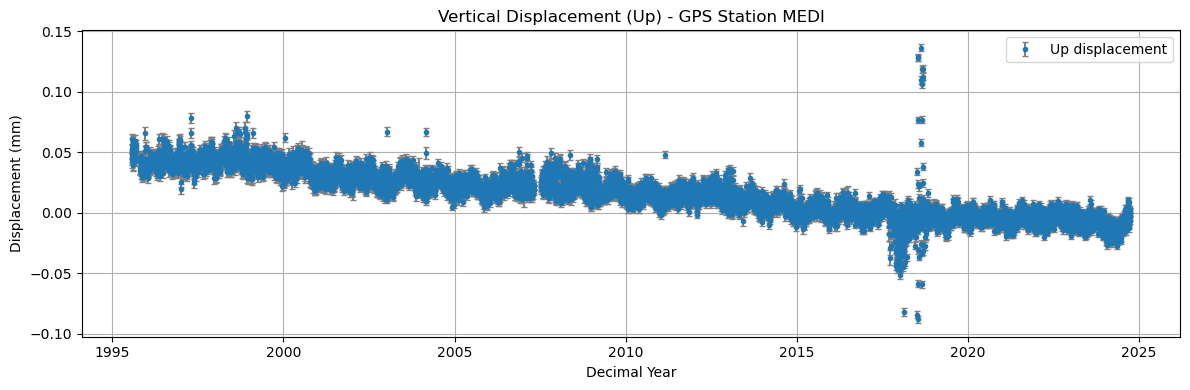

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.errorbar(df_gps['decimal_year'], df_gps['up'], yerr=df_gps['sig_u'],
             fmt='o', markersize=3, capsize=2, label='Up displacement', ecolor='gray')
plt.xlabel('Decimal Year')
plt.ylabel('Displacement (mm)')
plt.title('Vertical Displacement (Up) - GPS Station MEDI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
from pathlib import Path
import cdsapi

c = cdsapi.Client()

for year in range(2016, 2026):
    outfile = data_dir / f"era5_tcwv_{year}.nc"
    if outfile.exists():
        print(f"{outfile.name} already downloaded.")
        continue

    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': ['total_column_water_vapour'],
            'year': str(year),
            'month': [f"{m:02d}" for m in range(1, 13)],
            'day': [f"{d:02d}" for d in range(1, 32)],
            'time': ['12:00'],
            'format': 'netcdf',
            'area': [44.6, 11.2, 44.4, 11.5],  # [north, west, south, east]
        },
        str(outfile)
    )


2025-07-18 15:07:30,760 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-07-18 15:07:31,173 INFO Request ID is 0cf5acf7-192c-4f19-bdf7-71ad5bfd0f5c
2025-07-18 15:07:31,253 INFO status has been updated to accepted
2025-07-18 15:07:39,770 INFO status has been updated to successful
2025-07-18 15:07:41,192 INFO Request ID is 0930a117-6c08-456c-a36d-3361099e1ccb         
2025-07-18 15:07:41,261 INFO status has been updated to accepted
2025-07-18 15:07:49,707 INFO status has been updated to running
2025-07-18 15:09:35,381 INFO status has been updated to successful
2025-07-18 15:09:36,438 INFO Request ID is dc3cae28-f2ae-41b9-ae77-99de4abec30c         
2025-07-18 15:09:36,664 INFO status has been updated to accepted
2025-07-18 15:09:57,894 INFO status has been updated to running
2025-07-18 15:11:30,779 INFO status has been updated to successful
2025-07-18 15:11:31,939 INFO Request ID is bee63e7a-c837-4dff-a5b9-6322

## 3. Time-series Analysis with MintPy

### 3.1 Subset all GeoTIFFs to their common overlap

In [55]:
import sys
sys.path.append('/home/ubuntu/tools/MintPy/src')

from mintpy.cli import prep_hyp3
from mintpy.utils import readfile, writefile
from pathlib import Path
import os


In [65]:
print (f"Data directory: {data_dir}")

Data directory: /mnt/data/aoi_3_bologna


In [69]:
from mintpy.utils import writefile
print(dir(writefile))  # check if 'write_roipac_rsc' is listed


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'h5py', 'layout_hdf5', 'np', 'os', 'readfile', 'remove_hdf5_dataset', 'shutil', 'write', 'write_binary', 'write_bool', 'write_byte', 'write_complex_float32', 'write_complex_int16', 'write_float32', 'write_gdal_vrt', 'write_hdf5_block', 'write_isce_file', 'write_isce_xml', 'write_real_float32', 'write_real_float64', 'write_real_int16', 'write_roipac_rsc']


In [74]:
from mintpy import prep_hyp3
from mintpy.utils import readfile, writefile
from pathlib import Path


# Define file patterns to include
patterns = [
    "*unw_phase*.tif",
    "*corr*.tif",
    "*dem*.tif",
    "*lv_theta*.tif"
]

# Collect all matching files
all_tifs = []
for pat in patterns:
    all_tifs.extend(data_dir.rglob(pat))

# Loop through and write .rsc for each
for tif_file in sorted(all_tifs):
    try:
        print(f"Processing: {tif_file.name}")
        meta = readfile.read_gdal_vrt(str(tif_file))
        meta = prep_hyp3.add_hyp3_metadata(str(tif_file), meta)
        writefile.write_roipac_rsc(meta, str(tif_file) + ".rsc")
    except Exception as e:
        print(f"❌ Failed on {tif_file.name}: {e}")


Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_corr.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_corr_clipped.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_dem.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_dem_clipped.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_lv_theta.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_lv_theta_clipped.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_unw_phase.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_7568_unw_phase_clipped.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_974B_corr.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_974B_corr_clipped.tif
Processing: S1AA_20170110T052704_20170203T052703_VVP024_INT80_G_ueF_974B_dem.tif
Processing: S1AA_20170110T052704_20170203T0

In [63]:
import subprocess
from pathlib import Path

mintpy_input_dir = Path("/home/ubuntu/work/aoi_bologna/aoi_3_1/mintpy_inputs")
mintpy_input_dir.mkdir(exist_ok=True)

cmd = f"""
prep_hyp3.py \
--dir "{data_dir}" \
--outdir "{mintpy_input_dir}" \
--file "**/*unw_phase_clipped.tif" \
--coherence "**/*corr_clipped.tif" \
--ex "**/*dem_clipped.tif" \
--theta "**/*lv_theta_clipped.tif"
"""

subprocess.run(cmd, check=True, shell=True)


usage: prep_hyp3.py [-h] file [file ...]
prep_hyp3.py: error: unrecognized arguments: --dir --outdir /home/ubuntu/work/aoi_bologna/aoi_3_1/mintpy_inputs --file **/*unw_phase_clipped.tif --coherence **/*corr_clipped.tif --ex **/*dem_clipped.tif --theta **/*lv_theta_clipped.tif


CalledProcessError: Command '
prep_hyp3.py --dir "/mnt/data/aoi_3_bologna" --outdir "/home/ubuntu/work/aoi_bologna/aoi_3_1/mintpy_inputs" --file "**/*unw_phase_clipped.tif" --coherence "**/*corr_clipped.tif" --ex "**/*dem_clipped.tif" --theta "**/*lv_theta_clipped.tif"
' returned non-zero exit status 2.

In [34]:
from pathlib import Path
from typing import List, Union
from osgeo import gdal

def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of GeoTIFF files with correct projWin bounds."""
    corners = [gdal.Info(str(file), format='json')['cornerCoordinates'] for file in file_list]

    ulx = min(corner['upperLeft'][0] for corner in corners)
    uly = max(corner['upperLeft'][1] for corner in corners)
    lrx = max(corner['lowerRight'][0] for corner in corners)
    lry = min(corner['lowerRight'][1] for corner in corners)

    

    return [ulx, uly, lrx, lry]


'''
def get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files
    
    Arg:
        file_list: a list of GeoTIFF files
    
    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]
'''

'\ndef get_common_overlap(file_list: List[Union[str, Path]]) -> List[float]:\n    """Get the common overlap of  a list of GeoTIFF files\n\n    Arg:\n        file_list: a list of GeoTIFF files\n\n    Returns:\n         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y\n         corner coordinates of the common overlap\n    """\n\n    corners = [gdal.Info(str(dem), format=\'json\')[\'cornerCoordinates\'] for dem in file_list]\n\n    ulx = max(corner[\'upperLeft\'][0] for corner in corners)\n    uly = min(corner[\'upperLeft\'][1] for corner in corners)\n    lrx = min(corner[\'lowerRight\'][0] for corner in corners)\n    lry = max(corner[\'lowerRight\'][1] for corner in corners)\n    return [ulx, uly, lrx, lry]\n'

In [35]:
from osgeo import gdal
gdal.UseExceptions()
data_dir = Path(data_dir)
files = data_dir.glob('*/*_dem.tif')

overlap = get_common_overlap(files)

In [36]:
print(overlap)

[428520.0, 5126200.0, 747320.0, 4735720.0]


In [ ]:
##Modify later!

from osgeo import gdal

ds = gdal.Open("/path/to/any_dem_or_unw_phase_file.tif")
proj = ds.GetProjection()
print(gdal.Info(ds, format="json")['coordinateSystem'])

from shapely.geometry import box
from shapely.ops import transform
from pyproj import Transformer

# Define AOI in lon/lat (WGS84)
aoi_wgs84 = box(11.2, 44.4, 11.5, 44.6)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32633", always_xy=True)
aoi_utm33 = transform(transformer.transform, aoi_wgs84)

print("AOI in UTM 33N (EPSG:32633):", aoi_utm33.bounds)
(minx, miny, maxx, maxy) = aoi_utm33.bounds
# Equivalent to [ulx, uly, lrx, lry] for your AOI in meters
from shapely.geometry import box

overlap_box = box(overlap[0], overlap[3], overlap[2], overlap[1])  # minx, miny, maxx, maxy
print("Does overlap contain AOI?", overlap_box.contains(aoi_utm33))

In [41]:
## Check this alternative later ... !
# Clip all GeoTIFF files to their common overlap
from pathlib import Path
from typing import List, Union
from osgeo import gdal
from tqdm import tqdm

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap

    Args:
        data_dir: directory containing the GeoTIFF files to clip
        overlap: [ulx, uly, lrx, lry] of the common overlap area
    Returns: None
    """

    data_dir = Path(data_dir)
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:
        matching_files = list(data_dir.rglob(f'*{extension}'))
        for file in tqdm(matching_files, desc=f'Clipping {extension} files'):
            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'
            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)


In [37]:
from pathlib import Path
from typing import List, Union

def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [38]:
from osgeo import gdal
gdal.UseExceptions()

clip_hyp3_products_to_common_overlap(data_dir, overlap)

Warning 1: Computed -srcwin -146 -1150 3985 4881 falls partially outside source raster extent. Pixels outside the source raster extent will be set to the NoData value (if defined), or zero.
Warning 1: Computed -srcwin -326 -1382 3985 4881 falls partially outside source raster extent. Pixels outside the source raster extent will be set to the NoData value (if defined), or zero.
Warning 1: Computed -srcwin -146 -1152 3985 4881 falls partially outside source raster extent. Pixels outside the source raster extent will be set to the NoData value (if defined), or zero.
Warning 1: Computed -srcwin -142 -1152 3985 4881 falls partially outside source raster extent. Pixels outside the source raster extent will be set to the NoData value (if defined), or zero.
Warning 1: Computed -srcwin -354 -1158 3985 4881 falls partially outside source raster extent. Pixels outside the source raster extent will be set to the NoData value (if defined), or zero.
Warning 1: Computed -srcwin -146 -1152 3985 4881 f

### 3.2 Create the MintPy config file

In [50]:
mintpy_config = work_dir / 'mintpy_config.txt'
mintpy_config.write_text(
f"""
##---------processor info:
mintpy.load.processor        = hyp3

##---------interferogram datasets:
mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif

##---------geometry datasets:
mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif

##---------tropospheric delay correction:
mintpy.troposphericDelay.method        = weatherModel
mintpy.weatherModel.weatherModel       = ERA5
mintpy.weatherModel.weatherDir         = {data_dir}
mintpy.weatherModel.weatherFile        = era5_tcwv_*.nc
mintpy.weatherModel.heightRef          = auto

##---------additional options:
mintpy.network.inBaseline              = yes
mintpy.network.maxTempBaseline         = 180
mintpy.network.maxBTempBaseline        = 1500

mintpy.unwrapMask.connCompMinPix       = 100
mintpy.unwrapMask.maskFile             = auto

mintpy.waterBody.mask                  = auto
mintpy.reference.pixelMethod           = lonlat
mintpy.reference.lalo                  = 44.5199558120, 11.6468120447  # MEDI GPS lat, lon (adjusted from -348° to +11.65°)
mintpy.reference.interpMethod          = linear
mintpy.tempCohMask.min                 = 0.7
mintpy.deramp                          = quadratic
""")


1536

### 3.3 run MintPy to do the time series analysis

In [73]:
!smallbaselineApp.py --dir {work_dir} {mintpy_config}


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.6.1.post41, 2025-06-11
___________________________________________________________

--RUN-at-2025-07-18 18:59:23.322634--
Current directory: /home/ubuntu/work
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point', 'quick_overview', 'corre

In [ ]:
%matplotlib widget
from mintpy.cli import view, tsview

In [ ]:
view.main([f'{work_dir}/velocity.h5'])

In [ ]:
tsview.main([f'{work_dir}/timeseries.h5'])